In [14]:
# imports

import matplotlib.pyplot as plt
import numpy as np
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix
from pyquaternion import Quaternion


In [15]:

# basic config and variables
_VERSION = 'v1.0-mini'
_DATAROOT = '/home/valerius/data/sets/nuscenes'

nusc = NuScenes(version=_VERSION, dataroot=_DATAROOT, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.333 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [16]:
def get_pcd_data(nusc_filepath: str):
    radar_point_cloud = RadarPointCloud.from_file(nusc_filepath)
    points =  radar_point_cloud.points
    x = points[0]
    y = points[1]
    vx_comp = points[8]
    vy_comp = points[9]

    return {
        'file': nusc_filepath,
        'x': x,
        'y': y,
        'vx_comp': vx_comp,
        'vy_comp': vy_comp,
        'v_comp': (vx_comp ** 2 + vy_comp ** 2) ** 0.5,
        'radar_point_cloud': radar_point_cloud
    }

def extract_channel_from_file(channel: str):
    filename = nusc.get('sample_data', channel)['filename']
    filename = f'{_DATAROOT}/{filename}'
    return get_pcd_data(filename)


def extract_samples_from_scene(scene: dict):
    """extract all the samples related to the given scene."""
    first_sample_token = scene['first_sample_token']
    last_sample_token = scene['last_sample_token']
    samples = list()

    fst = nusc.get('sample', first_sample_token)
    next_token = fst['next']
    while True:
        current = nusc.get('sample', next_token)
        samples.append(current)
        next_token = current['next']
        if next_token == last_sample_token:
            return samples


def convert_binary_data_to_coordinates_and_velocity(sample: dict):
    data = sample['data']
    return {
     'RADAR_FRONT' : extract_channel_from_file(data['RADAR_FRONT']),
     'RADAR_FRONT_LEFT' : extract_channel_from_file(data['RADAR_FRONT_LEFT']),
     'RADAR_FRONT_RIGHT' : extract_channel_from_file(data['RADAR_FRONT_RIGHT']),
     'RADAR_BACK_LEFT' : extract_channel_from_file(data['RADAR_BACK_LEFT']),
     'RADAR_BACK_RIGHT' : extract_channel_from_file(data['RADAR_BACK_RIGHT']),
     'data': data
    }

sc = nusc.scene[0]
samples_from_scene = extract_samples_from_scene(sc)
scene_in_sample_data = [convert_binary_data_to_coordinates_and_velocity(sc) for sc in samples_from_scene]


In [17]:
def new_method():
    """makes a biggo matrix containing all infos about 2 a)."""
    channels = [
        'RADAR_FRONT',
        'RADAR_FRONT_LEFT',
        'RADAR_FRONT_RIGHT',
        'RADAR_BACK_LEFT',
        'RADAR_BACK_RIGHT',
    ]
    samples = scene_in_sample_data
    scene_points = list()
    for sample in samples:
        x, y, z, vx_comp, vy_comp, pointclouds = list(), list(), list() ,list() ,list(), list()
        for channel in channels:
            pc = sample[channel]['radar_point_cloud']
            radar_token = sample['data'][channel]
            current_radar = nusc.get('sample_data', radar_token)
            ego_pose = nusc.get('ego_pose', current_radar['ego_pose_token'])
            calibrated_sensor = nusc.get('calibrated_sensor', current_radar['calibrated_sensor_token'])
            sensor_to_car = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation'], inverse=False))
            car_to_world = transform_matrix(ego_pose['translation'], Quaternion(ego_pose['rotation'], inverse=False))

            sensor_to_world = car_to_world @ sensor_to_car

            pc.transform(sensor_to_world)

            pointclouds.append(pc)

            # combine radar
            for i in range(pc.points.shape[1]):
                x.append(pc.points[0][i])
                y.append(pc.points[1][i])
                z.append(pc.points[2][i]) # redundant?
                vx_comp.append(pc.points[7][i])
                vy_comp.append(pc.points[8][i])
        scene_points.append([
            np.asarray(x),
            np.asarray(y),
            np.asarray(z),
            np.asarray(vx_comp),
            np.asarray(vy_comp),
            np.asarray(pointclouds)
        ])

    return np.asarray(scene_points)


result = new_method()

/tmp/ipykernel_248478/1601697810.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(scene_points)


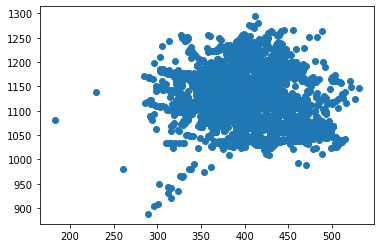

In [18]:
ys = list()
xs = list()

for row in result:
    x, y = row[0], row[1]
    xs += list(x)
    ys += list(y)

# TODO: Ego pose in rot plotten
# TODO: marker size
# TODO: ausschnitt
# TODO: fahrzeug plotten

plt.scatter(x=xs, y=ys)
plt.show()